# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [35]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing   
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 4000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (4000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(3989, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.725

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(3989, 10)


1    3328
0     661
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Fast, professional transaction.  I needed this one ingredient for a new recipe and it turned out great!  Now I just need to find more uses for this stuff.
Please ignore the one-star comments, if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower. With anything that is gluten free you have to add another "binder" which is where the corn flour comes in. For someone who has celiac disease and cannot have Sunchips, because they contain wheat (a key binder to any chip, cookie or cereal) this is an excellent product. My spouse and I buy these a lot because they are gluten free and absolutely delicious!


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
#sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)


We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Fast, professional transaction.  I needed this one ingredient for a new recipe and it turned out great!  Now I just need to find more uses for this stuff.
Please ignore the one-star comments, if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower. With anything that is gluten free you have to add another "binder" which is where the corn flour comes in. For someone who has celiac disease and cannot have Sunchips, because they contain wheat (a key binder to any chip, cookie or cereal) this is an excellent product. My spouse and I buy these a lot because they are gluten free and absolutely delicious!


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Please ignore the one-star comments, if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower. With anything that is gluten free you have to add another "binder" which is where the corn flour comes in. For someone who has celiac disease and cannot have Sunchips, because they contain wheat (a key binder to any chip, cookie or cereal) this is an excellent product. My spouse and I buy these a lot because they are gluten free and absolutely delicious!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Please ignore the one star comments if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower With anything that is gluten free you have to add another binder which is where the corn flour comes in For someone who has celiac disease and cannot have Sunchips because they contain wheat a key binder to any chip cookie or cereal this is an excellent product My spouse and I buy these a lot because they are gluten free and absolutely delicious 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_a = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_a.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 3989/3989 [00:01<00:00, 3191.95it/s]


In [23]:
preprocessed_reviews_a[1500]

'please ignore one star comments check bag main ingredient fact whole grain brown rice second rice flower anything gluten free add another binder corn flour comes someone celiac disease cannot sunchips contain wheat key binder chip cookie cereal excellent product spouse buy lot gluten free absolutely delicious'

In [24]:
X = preprocessed_reviews_a

# [4] Featurization

## [4.1] BAG OF WORDS

In [205]:
#BoW
vectorizer = CountVectorizer(min_df = 10)
vectorizer.fit(X) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:20])# printing some feature names
print("="*50)

# we use the fitted CountVectorizer to convert the text to vector
X_bow = vectorizer.transform(X)

print("After vectorizations")
print(X_bow.shape)

['able', 'absolute', 'absolutely', 'according', 'acid', 'across', 'actual', 'actually', 'add', 'added', 'addicted', 'addicting', 'addictive', 'adding', 'addition', 'additionally', 'additives', 'adds', 'admit', 'adult']
After vectorizations
(3989, 1885)


## [4.3] TF-IDF

In [206]:
tfidf_vect = TfidfVectorizer(min_df=10)
tfidf_vect.fit(X)
print("some sample features ",tfidf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_tfidf = tfidf_vect.transform(X)

print("After vectorizations")
print(X_tfidf.shape)


some sample features  ['able', 'absolute', 'absolutely', 'according', 'acid', 'across', 'actual', 'actually', 'add', 'added']
After vectorizations
(3989, 1885)


## [4.4] Word2Vec

In [25]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [26]:
# this line of code trains your w2v model on the give list of sentances, fitting the data
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=-1)

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3295
sample words  ['used', 'ca', 'not', 'beat', 'great', 'product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'everybody', 'asks', 'bought', 'made', 'two']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
print(sent_vectors.shape)
print(sent_vectors[0])

100%|████████████████████████████████████████████████████████████████████████████| 3989/3989 [00:02<00:00, 1547.61it/s]


(3989, 50)
[-2.08258765e-04 -8.50573182e-04  2.57958284e-03  2.20642064e-03
 -1.71055952e-03 -3.63902928e-03 -6.52334265e-04 -5.79028856e-05
 -7.47786544e-04  3.84051945e-03  6.23511267e-04 -1.74325439e-03
 -1.89252077e-03 -3.41529450e-03 -2.72196962e-03  6.18074198e-03
 -1.91327788e-03 -1.91387531e-03  1.19264730e-03  3.76884969e-03
 -3.26800897e-04 -4.88491396e-03 -5.03189743e-03  5.63717913e-04
  3.16440483e-03 -1.71693283e-03  2.64091755e-03  1.90477484e-03
 -1.91613872e-05  6.20621620e-04  9.31884861e-04 -2.53918026e-03
 -1.32379202e-03 -3.06696869e-03  3.17091262e-03  1.44844991e-04
 -3.40751510e-03 -7.03583501e-05  2.41178134e-03 -4.22656394e-03
 -5.21609705e-04 -2.34397727e-03  1.75464394e-03  6.09099118e-04
 -6.44757223e-04  1.30831664e-03 -6.67121669e-04  2.37091296e-03
  2.22094264e-03  7.60357982e-04]


In [211]:
type(sent_vectors)

numpy.ndarray

#### [4.4.1.2] TFIDF weighted W2v

In [29]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [30]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3989/3989 [00:13<00:00, 289.11it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [85]:
from datetime import datetime
start = datetime.now()

k = [2,3,4,5,6,7,8,9]
inertia_values_bow = []
for i in k:
    k_means_bow = KMeans(random_state=0, n_clusters=i)
    k_means_bow = k_means_bow.fit(X_bow)
    inertia_values_bow.append(k_means_bow.inertia_)

print("DONE")

print("Time taken = ", datetime.now()-start)

DONE
Time taken =  1:30:41.395055


In [51]:
print(len(inertia_values_bow))

8


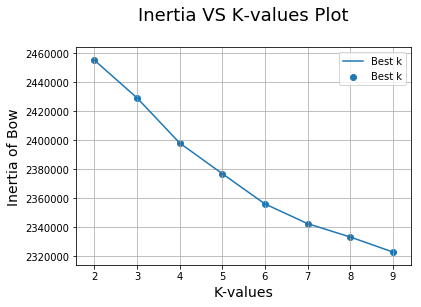

In [87]:
plt.plot(k, inertia_values_bow, label='Best k')
plt.scatter(k, inertia_values_bow, label='Best k')

plt.legend()
plt.xlabel('K-values',size=14)
plt.ylabel('Inertia of Bow',size=14)
plt.title('Inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

#### Here we are taking best value of k = 5 

In [94]:
kmeans_bow_best = KMeans(n_clusters=5, random_state=0)
kmeans_bow_best = kmeans_bow_best.fit(X_bow)

In [109]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans_bow_best.labels_.shape[0]):
    if kmeans_bow_best.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans_bow_best.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans_bow_best.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans_bow_best.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        

In [111]:
type(cluster1)

list

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

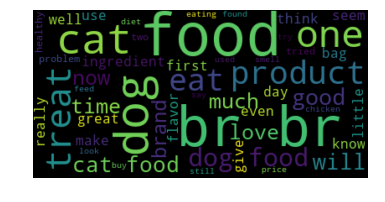

In [116]:
text=str(cluster1)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [110]:
type(text)

str

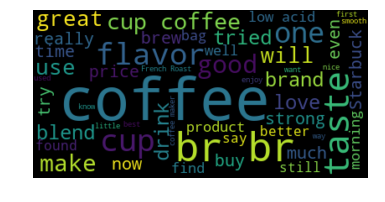

In [104]:
text = str(cluster2)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

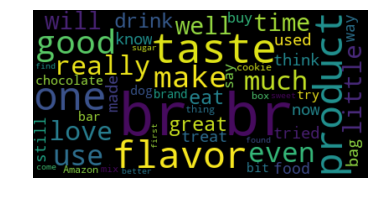

In [105]:
text = str(cluster3)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

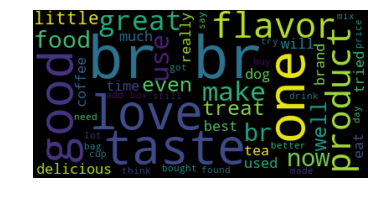

In [106]:
text = str(cluster4)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

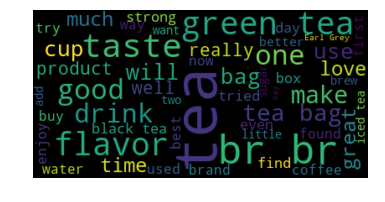

In [107]:
text = str(cluster5)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [88]:
from datetime import datetime
start = datetime.now()

k = [2,3,4,5,6,7,8,9]
inertia_values_tfidf = []
for i in k:
    k_means_tfidf = KMeans(random_state=0, n_clusters=i)
    k_means_tfidf = k_means_tfidf.fit(X_tfidf)
    inertia_values_tfidf.append(k_means_tfidf.inertia_)

print("DONE")

print("Time taken = ", datetime.now()-start)

DONE
Time taken =  1:52:34.954290


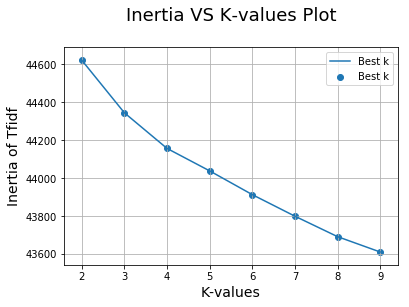

In [89]:
plt.plot(k, inertia_values_tfidf , label='Best k')
plt.scatter(k, inertia_values_tfidf, label='Best k')

plt.legend()
plt.xlabel('K-values',size=14)
plt.ylabel('Inertia of Tfidf',size=14)
plt.title('Inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

#### Here we are taking best value of k = 4 

In [95]:
kmeans_tfidf_best = KMeans(n_clusters=4, random_state=0)
kmeans_tfidf_best = kmeans_tfidf_best.fit(X_tfidf)

In [125]:
cluster_t1 = []
cluster_t2 = []
cluster_t3 = []
cluster_t4 = []

for i in range(kmeans_tfidf_best.labels_.shape[0]):
    if kmeans_tfidf_best.labels_[i] == 0:
        cluster_t1.append(reviews[i])
    elif kmeans_tfidf_best.labels_[i] == 1:
        cluster_t2.append(reviews[i])
    elif kmeans_tfidf_best.labels_[i] == 2:
        cluster_t3.append(reviews[i])
    else :
        cluster_t4.append(reviews[i]) 

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

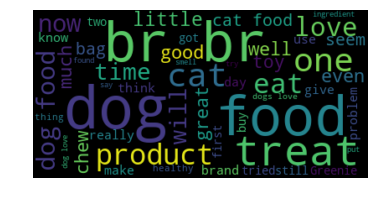

In [119]:
text = str(cluster_t1)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

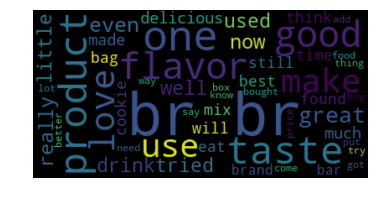

In [120]:
text = str(cluster_t2)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

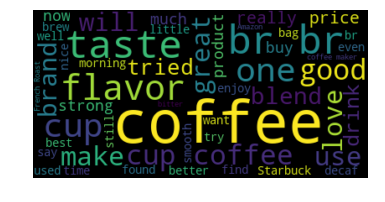

In [121]:
text = str(cluster_t3)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

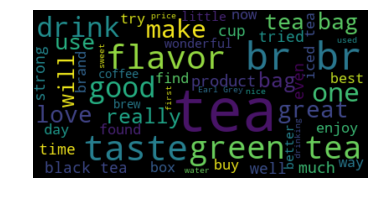

In [126]:
text = str(cluster_t4)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [90]:
from datetime import datetime
start = datetime.now()

k = [2,3,4,5,6,7,8,9]
inertia_values_aw2v = []
for i in k:
    k_means_aw2v = KMeans(random_state=0, n_clusters=i)
    k_means_aw2v = k_means_aw2v.fit(sent_vectors)
    inertia_values_aw2v.append(k_means_aw2v.inertia_)

print("DONE")

print("Time taken = ", datetime.now()-start)

DONE
Time taken =  0:01:06.635534


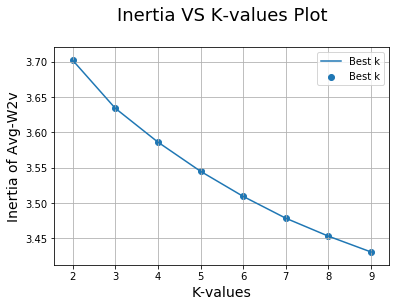

In [91]:
plt.plot(k, inertia_values_aw2v, label='Best k')
plt.scatter(k, inertia_values_aw2v, label='Best k')

plt.legend()
plt.xlabel('K-values',size=14)
plt.ylabel('Inertia of Avg-W2v',size=14)
plt.title('Inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

#### Here we are taking best value of k = 3 

In [127]:
kmeans_aw2v_best = KMeans(n_clusters=3, random_state=0)
kmeans_aw2v_best = kmeans_aw2v_best.fit(sent_vectors)

In [138]:
cluster_a1 = []
cluster_a2 = []
cluster_a3 = []

for i in range(kmeans_aw2v_best.labels_.shape[0]):
    if kmeans_aw2v_best.labels_[i] == 0:
        cluster_a1.append(reviews[i])
    elif kmeans_aw2v_best.labels_[i] == 1:
        cluster_a2.append(reviews[i])
    else :
        cluster_a3.append(reviews[i]) 

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

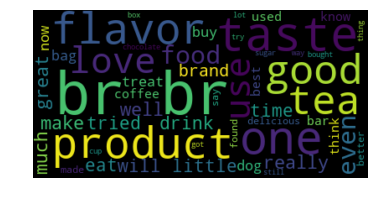

In [129]:
text = str(cluster_a1)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

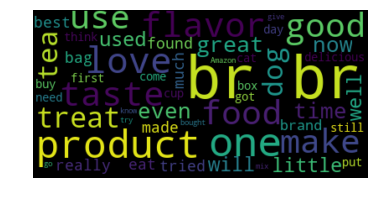

In [130]:
text = str(cluster_a2)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

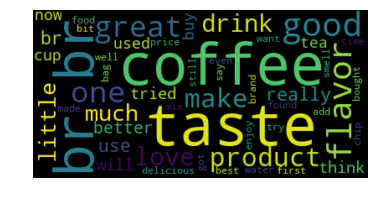

In [139]:
text = str(cluster_a3)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
k = [2,3,4,5,6,7,8,9]
inertia_values_tfw2v = []
for i in k:
    k_means_tfw2v = KMeans(random_state=0, n_clusters=i)
    k_means_tfw2v = k_means_tfw2v.fit(tfidf_sent_vectors)
    inertia_values_tfw2v.append(k_means_tfw2v.inertia_)

print("DONE")

DONE


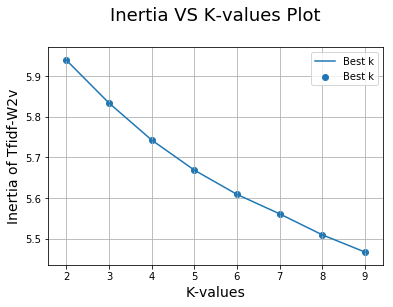

In [93]:
plt.plot(k, inertia_values_tfw2v, label='Best k')
plt.scatter(k, inertia_values_tfw2v, label='Best k')

plt.legend()
plt.xlabel('K-values',size=14)
plt.ylabel('Inertia of Tfidf-W2v',size=14)
plt.title('Inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

#### Here we are taking best value of k = 4 

In [140]:
kmeans_tfw2v_best = KMeans(n_clusters=4, random_state=0)
kmeans_tfw2v_best = kmeans_tfw2v_best.fit(tfidf_sent_vectors)

In [141]:
cluster_w1 = []
cluster_w2 = []
cluster_w3 = []
cluster_w4 = []

for i in range(kmeans_tfw2v_best.labels_.shape[0]):
    if kmeans_tfw2v_best.labels_[i] == 0:
        cluster_w1.append(reviews[i])
    elif kmeans_tfw2v_best.labels_[i] == 1:
        cluster_w2.append(reviews[i])
    elif kmeans_tfw2v_best.labels_[i] == 2:
        cluster_w3.append(reviews[i])
    else :
        cluster_w4.append(reviews[i]) 

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

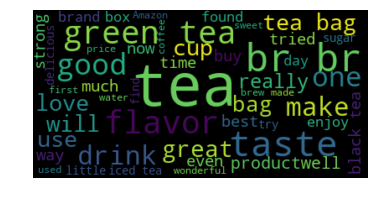

In [142]:
text = str(cluster_w1)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

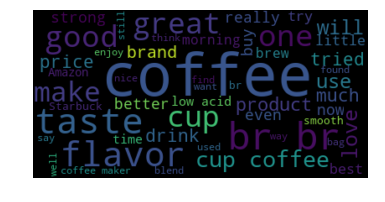

In [143]:
text = str(cluster_w2)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

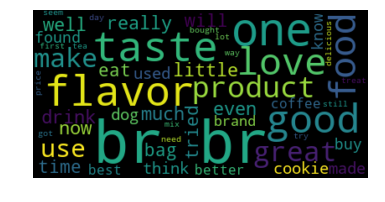

In [144]:
text = str(cluster_w3)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

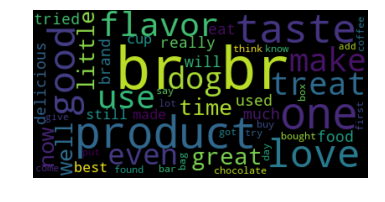

In [145]:
text = str(cluster_w4)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

### For Clusters = 2 

In [214]:
agglo_aw2v_2 = AgglomerativeClustering(n_clusters=2)
agglo_aw2v_2 = agglo_aw2v_2.fit(sent_vectors)

In [225]:
cluster_a12 = []
cluster_a22 = []

for i in range(agglo_aw2v_2.labels_.shape[0]):
    if agglo_aw2v_2.labels_[i] == 0:
        cluster_a12.append(reviews[i])
    else :
        cluster_a22.append(reviews[i]) 

### For Clusters = 4 

In [215]:
agglo_aw2v_4 = AgglomerativeClustering(n_clusters=4)
agglo_aw2v_4 = agglo_aw2v_4.fit(sent_vectors)

In [228]:
cluster_a14 = []
cluster_a24 = []
cluster_a34 = []
cluster_a44 = []

for i in range(agglo_aw2v_4.labels_.shape[0]):
    if agglo_aw2v_4.labels_[i] == 0:
        cluster_a14.append(reviews[i])
    elif agglo_aw2v_4.labels_[i] == 1:
        cluster_a24.append(reviews[i])
    elif agglo_aw2v_4.labels_[i] == 2:
        cluster_a34.append(reviews[i])
    else :
        cluster_a44.append(reviews[i]) 

### For Clusters = 5 

In [216]:
agglo_aw2v_5 = AgglomerativeClustering(n_clusters=5)
agglo_aw2v_5 = agglo_aw2v_5.fit(sent_vectors)

In [233]:
cluster_a15 = []
cluster_a25 = []
cluster_a35 = []
cluster_a45 = []
cluster_a55 = []

for i in range(agglo_aw2v_5.labels_.shape[0]):
    if agglo_aw2v_5.labels_[i] == 0:
        cluster_a15.append(reviews[i])
    elif agglo_aw2v_5.labels_[i] == 1:
        cluster_a25.append(reviews[i])
    elif agglo_aw2v_5.labels_[i] == 2:
        cluster_a35.append(reviews[i])
    elif agglo_aw2v_5.labels_[i] == 3:
        cluster_a45.append(reviews[i])
    else :
        cluster_a55.append(reviews[i]) 

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

#### For n_clusters=2

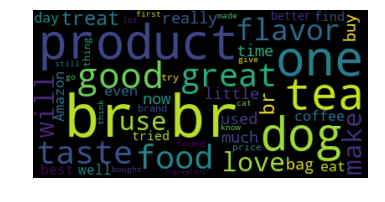

In [226]:
text = str(cluster_a12)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

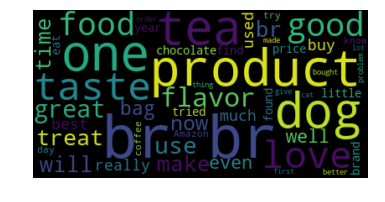

In [227]:
text = str(cluster_a22)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### For n_clusters=4 

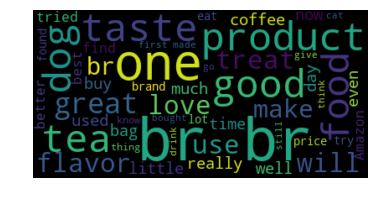

In [229]:
text = str(cluster_a14)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

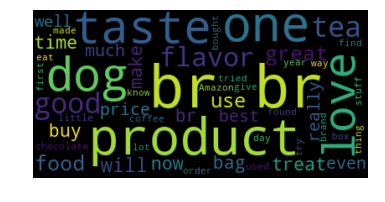

In [230]:
text = str(cluster_a24)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

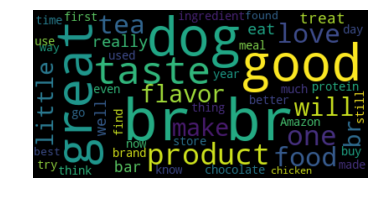

In [231]:
text = str(cluster_a34)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

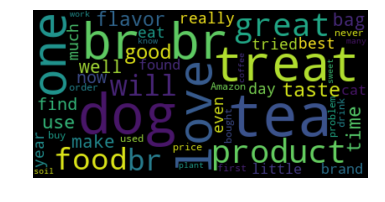

In [232]:
text = str(cluster_a44)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### For n_clusters=5 

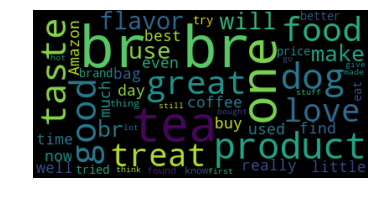

In [234]:
text = str(cluster_a15)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

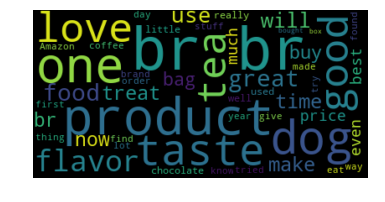

In [235]:
text = str(cluster_a25)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

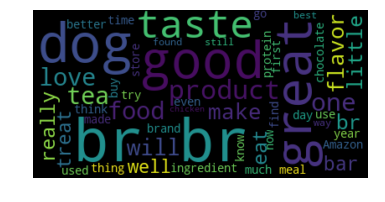

In [236]:
text = str(cluster_a35)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

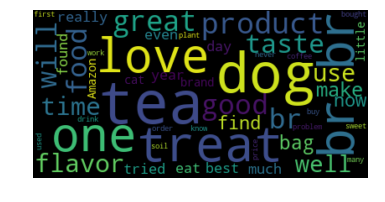

In [237]:
text = str(cluster_a45)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

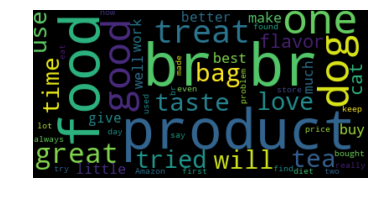

In [238]:
text = str(cluster_a55)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

### For Clusters = 2 

In [239]:
agglo_tfw2v_2 = AgglomerativeClustering(n_clusters=2)
agglo_tfw2v_2 = agglo_tfw2v_2.fit(tfidf_sent_vectors)

In [240]:
cluster_w12 = []
cluster_w22 = []

for i in range(agglo_tfw2v_2.labels_.shape[0]):
    if agglo_tfw2v_2.labels_[i] == 0:
        cluster_w12.append(reviews[i])
    else :
        cluster_w22.append(reviews[i]) 

### For Clusters = 3 

In [241]:
agglo_tfw2v_3 = AgglomerativeClustering(n_clusters=3)
agglo_tfw2v_3 = agglo_tfw2v_3.fit(tfidf_sent_vectors)

In [242]:
cluster_w13 = []
cluster_w23 = []
cluster_w33 = []

for i in range(agglo_tfw2v_3.labels_.shape[0]):
    if agglo_tfw2v_3.labels_[i] == 0:
        cluster_w13.append(reviews[i])
    elif agglo_tfw2v_3.labels_[i] == 1:
        cluster_w23.append(reviews[i])
    else :
        cluster_w33.append(reviews[i]) 

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

#### For n_clusters = 2 

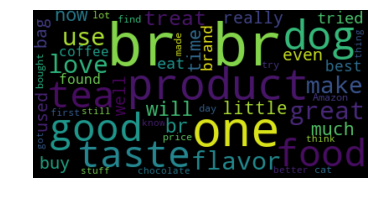

In [243]:
text = str(cluster_w12)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

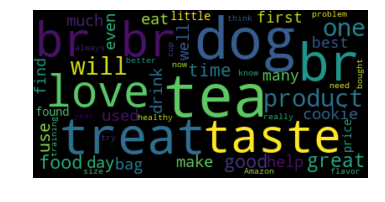

In [244]:
text = str(cluster_w22)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### For n_clusters = 3 

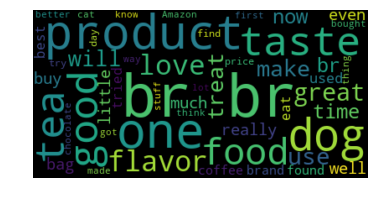

In [245]:
text = str(cluster_w13)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

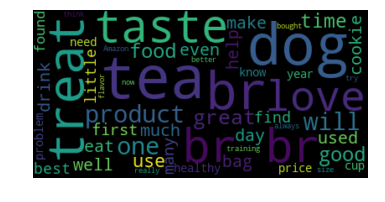

In [246]:
text = str(cluster_w23)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

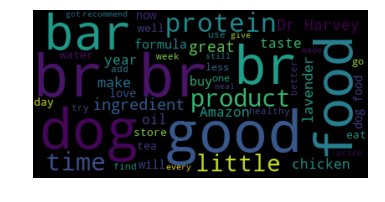

In [247]:
text = str(cluster_w33)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

#### To find correct eps

In [45]:
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
aw2v_data= scaler.fit_transform(sent_vectors)

In [46]:
min_pts=2*aw2v_data.shape[1]
distances=[]

for data in aw2v_data:
    temp_dist=np.sort(np.sum((aw2v_data-data)**2,axis=1),axis=None)
    distances.append(temp_dist[100])
    
sorted_distances=np.sort(distances)
pt_index=[i for i in range(aw2v_data.shape[0])]

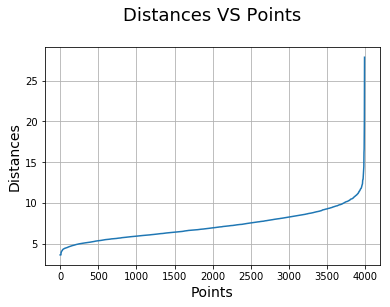

In [47]:
# Plotting distances VS points 
import matplotlib.pyplot as plt
plt.plot(pt_index, np.sqrt(sorted_distances))
plt.xlabel('Points',size=14)
plt.ylabel('Distances',size=14)
plt.title('Distances VS Points\n',size=18)
plt.grid()
plt.show()

#### Here we are taking optimal value for eps = 11

In [39]:
dbscan_aw2v_best = DBSCAN(eps=11, n_jobs=-1)
dbscan_aw2v_best = dbscan_aw2v_best.fit(sent_vectors)

In [42]:
reviews = final['Text'].values

cluster_a1 = []

for i in range(dbscan_aw2v_best.labels_.shape[0]):
    if dbscan_aw2v_best.labels_[i] == 0:
        cluster_a1.append(reviews[i])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

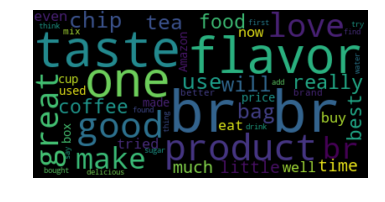

In [43]:
text = str(cluster_a1)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

#### To find correct eps 

In [48]:
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
tfw2v_data= scaler.fit_transform(tfidf_sent_vectors)

In [49]:
min_pts=2*tfw2v_data.shape[1]
distances=[]

for data in tfw2v_data:
    temp_dist=np.sort(np.sum((tfw2v_data-data)**2,axis=1),axis=None)
    distances.append(temp_dist[100])
    
sorted_distances=np.sort(distances)
pt_index=[i for i in range(tfw2v_data.shape[0])]

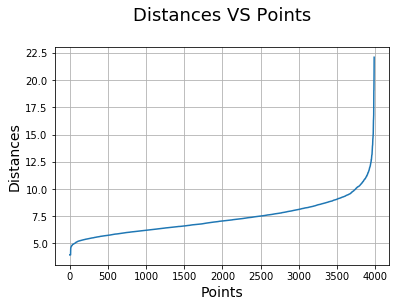

In [50]:
# Plotting distances VS points 
import matplotlib.pyplot as plt
plt.plot(pt_index, np.sqrt(sorted_distances))
plt.xlabel('Points',size=14)
plt.ylabel('Distances',size=14)
plt.title('Distances VS Points\n',size=18)
plt.grid()
plt.show()

#### Here we are taking optimal value of eps = 10 

In [51]:
dbscan_tfw2v_best = DBSCAN(eps=10, n_jobs=-1)
dbscan_tfw2v_best = dbscan_tfw2v_best.fit(tfidf_sent_vectors)

In [52]:
cluster_w1 = []

for i in range(dbscan_tfw2v_best.labels_.shape[0]):
    if dbscan_tfw2v_best.labels_[i] == 0:
        cluster_w1.append(reviews[i])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

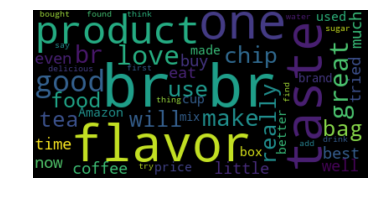

In [53]:
text = str(cluster_w1)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=70, max_words=50, background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# [6] Conclusions

In [276]:
number= [1,2,3,4]
cluster= ["K-means", "K-means", "K-means", "K-means"]
model= ["Bow", "Tfidf", "Avg-w2v", "Tfidf-w2v"]
k = ["5", "4", "3", "4"]

#Initialize Prettytable
ptable = PrettyTable()
ptable.add_column("Index", number)
ptable.add_column("Clustering", cluster)
ptable.add_column("Model", model)
ptable.add_column("n_clusters", k)

print(ptable)

+-------+------------+-----------+------------+
| Index | Clustering |   Model   | n_clusters |
+-------+------------+-----------+------------+
|   1   |  K-means   |    Bow    |     5      |
|   2   |  K-means   |   Tfidf   |     4      |
|   3   |  K-means   |  Avg-w2v  |     3      |
|   4   |  K-means   | Tfidf-w2v |     4      |
+-------+------------+-----------+------------+


In [277]:
number= [1,2]
cluster= ["Agglomerative", "Agglomerative"]
model= ["Avg-w2v", "Tfidf-w2v"]
k = ["2,4,5", "2,3"]

#Initialize Prettytable
ptable = PrettyTable()
ptable.add_column("Index", number)
ptable.add_column("Clustering", cluster)
ptable.add_column("Model", model)
ptable.add_column("n_clusters", k)

print(ptable)

+-------+---------------+-----------+------------+
| Index |   Clustering  |   Model   | n_clusters |
+-------+---------------+-----------+------------+
|   1   | Agglomerative |  Avg-w2v  |   2,4,5    |
|   2   | Agglomerative | Tfidf-w2v |    2,3     |
+-------+---------------+-----------+------------+


In [54]:
number= [1,2]
cluster= ["DBSCAN", "DBSCAN"]
model= ["Avg-w2v", "Tfidf-w2v"]
e = ["11", "10"]

#Initialize Prettytable
ptable = PrettyTable()
ptable.add_column("Index", number)
ptable.add_column("Clustering", cluster)
ptable.add_column("Model", model)
ptable.add_column("Best eps", e)

print(ptable)

+-------+------------+-----------+----------+
| Index | Clustering |   Model   | Best eps |
+-------+------------+-----------+----------+
|   1   |   DBSCAN   |  Avg-w2v  |    11    |
|   2   |   DBSCAN   | Tfidf-w2v |    10    |
+-------+------------+-----------+----------+


1. For K-means we have taken 50000 datapoints and for Agglomerative and DBSCAN we have taken 4000 datapoints each.
2. While implementing K-means, best value for n_clusters for all models is find using elbow-knee method
3. For Agglomerative clustering, we have taken different values of n_clusters(2,3,4,5) for Avg-w2v model and tfidf-w2v.
4. Similarly in DBSCAN clustering, we have taken different values of eps(1,3,5,7) for both models.
5. For DBSCAN, just one cluster is plotted for each model.
6. Each cluster includes words related to some particular data.